# NBA Play-Off Simulation
----
Anton Buguev, Innopolis University

December 2023

Basketball is one of the most popular sports in the world [(1)](https://news.topsport.com.au/ranked-the-worlds-most-popular-sports/), [(2)](https://thesporting.blog/blog/the-most-popular-sports-in-the-world) while the most popular basketball league is definitely the National Basketball Association (NBA) [(3)](https://www.onlinebettingacademy.com/blog/2023/06/top-ten-basketball-leagues). Images below show only small part of the best NBA players that a lot of unfamiliar people probably know as well. These players have already earned (or will earn) the place in NBA Hall of Fame.


| <img src="images/kobe_shaq.png" height="350" alt="Kobe Bryant and Shaquille O'Neal"/> | <img src="images/michael.png" height="350" alt="Michael Jordan"/> | 
|:--:|:--:| 
| <font size="5">Kobe Bryant (8) and Shaquille O'Neal (34)</font>| <font size="5">Michael Jordan</font> |
| <img src="images/lebron_wade.png" height="350" alt="LeBron James"/> | <img src="images/tima.png" height="350" alt="Stephen Curry"/> | 
| <font size="5">LeBron James (6) and Dwyane Wade (3)</font>| <font size="5">Timofey Mozgov - 2015/16 NBA champion</font> |

*P.S. There was a typo in Mozgov's score, he definitely earned less points, it is just a joke*
<!-- *Table (1): One of the best and famous NBA players* -->


Any basketball fan would love to attend the NBA match in real life. Unfortunately, a lot of fans (like me) live on other half of the world, which makes it difficult to attend or even watch matches online due to the different time-zones. For example, if you live in Moscow time-zone, then matches start around **1AM** and end at **7AM** (if you want to watch several games). Hence, we either have to sacrifice our sleep schedule or skip match of the favourite team. What would be even more sad if you decide to wake up early and your team loses.

Therefore, the idea for my project arised. What if I can predict the match outcome (at least approximately) and decide if I want to sacrifice my sleep for that night. However, predicting each match would be the tedious task. Moreover, I need some data to use as foundation for predictions and since each season players switch teams, predictions would be wrong for first games. Hence, I decided to simulate only Play-Off stages. The basic steps are the following:
1. Extract mathces results for given season with detailed statistics;
2. Train Machine Learning (ML) model on that data;
3. Insert teams participating in Play-Off;
4. Simulate each Play-off round for each pair of teams eventually predicting the champion.

So let us get started.


## Extra class for colourful output

In [1]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Part 1. Model selection

First, we need to select appropriate ML model for correct predictions. Since we just need to predict which team out of 2 wins in a match, this is just classification problem, therefore I used standard models for binary classification:
- Logistic regression
- Naïve Bayes
- K-nearest neighbours (KNN)
- Decision Tree
- Random Forest
- Support Vector Classifier (SVC)

For each of the models we will tune hyper-parameters and check which of them shows the best performance.

### Import data

For this project I used dataset from [Kaggle](https://www.kaggle.com/datasets/nathanlauga/nba-games/data) that was collected from website with detailed statistic [Basketball reference](https://www.basketball-reference.com/). The main datasets that we will use are `games.csv` (games information) and `teams.csv` (teams information for convenient visualization). However, I added 2 extra files with season schedule (`season_schedule.csv`) and teams participating in Play-Off for given seasons (`play_off_teams.csv`). Of course Play-off pairs generation may be automated, because there is table with team ranking but we would need to apply many filters to get useful information and handle situations if some teams have the same number of wins in season, so let us use hand-written data for now.

#### Games information

Let us ppreprocess data right away:
* Scale columns with team IDs because initially this column contained 10-digit numbers, but there are only 30 teams in NBA
* Drop columns **TEAM_ID_home** and **TEAM_ID_away** because the just duplicated teams IDs from columns **HOME_TEAM_ID** and **VISITOR_TEAM_ID** respectively
* Table contains incomplete information for games before 2004, so we keep games only after that year

Now let us analyze the data  to understand what we have here 
+ **GAME_DATE_EST**: date of the game, this will be used to distinguish regular season games from play-off games
- **GAME_ID**: not really useful column, we will drop it later
- **GAME_STATUS_TEXT**: also not useful column, *Final* just means that game has finished (*e.g.* we load data during the game, the status would be different)
+ **HOME_TEAM_ID**: ID of home team, we will use it
+ **VISITOR_TEAM_ID**: ID of visitor team, also will use it
+ **SEASON**: season year, will also be used to sort games for given season (but can use just first column)
- **PTS_home**: number of points home team earned, this column will not be used because in that case all other columns are not neccessary
+ **FG_PCT_home**: percentage of successfull shot attempts of home team
+ **FT_PCT_home**: percentage of successfull free-throw (after foul) attempts of home team
+ **FG3_PCT_home**: percentage of successfull 3-point shot attempts of home team
+ **AST_home**: number of assists of home team, it shows how good the ball movement is, so we will use this column
+ **REB_home**: number of rebounds of home team, it shows how good team gets the ball after failed shot attempt during attack and defense, so we also need this column
- **PTS_away**: number of points visitor team earned, also will not be used by the same reason
+ **FG_PCT_away**: percentage of successfull shot attempts of visitor team
+ **FT_PCT_away**: percentage of successfull free-throw (after foul) attempts of visitor team
+ **FG3_PCT_away**: percentage of successfull 3-point shot attempts of visitor team
+ **AST_away**: number of assists of visitor team
+ **REB_away**: number of rebounds of visitor team
+ **HOME_TEAM_WINS**: 1 - home team wins, 0 - otherwise. This will be our target

In [41]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict

df_games = pd.read_csv('data/games.csv').drop(["TEAM_ID_home", "TEAM_ID_away"], axis=1) # open data without 2 columns wit hteam IDs
df_games = df_games.loc[df_games["SEASON"] >= 2004] # store games starting from season 2004

scaler = MinMaxScaler()
cols_to_norm = ["HOME_TEAM_ID", "VISITOR_TEAM_ID"]
df_games.loc[:, cols_to_norm] = scaler.fit_transform(df_games.loc[:, cols_to_norm]) # scale team IDs
df_games

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,0.103448,0.758621,2022,126.0,0.484,0.926,0.382,25.0,46.0,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,0.862069,0.931034,2022,120.0,0.488,0.952,0.457,16.0,40.0,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,0.068966,0.413793,2022,114.0,0.482,0.786,0.313,22.0,37.0,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,0.620690,0.965517,2022,113.0,0.441,0.909,0.297,27.0,49.0,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,0.000000,0.137931,2022,108.0,0.429,1.000,0.378,22.0,47.0,110.0,0.500,0.773,0.292,20.0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26646,2014-10-06,11400007,Final,0.000000,0.103448,2014,93.0,0.419,0.821,0.421,24.0,50.0,87.0,0.366,0.643,0.375,17.0,43.0,1
26647,2014-10-06,11400004,Final,0.137931,0.931034,2014,81.0,0.338,0.719,0.381,18.0,40.0,85.0,0.411,0.636,0.267,17.0,47.0,0
26648,2014-10-06,11400005,Final,0.344828,0.206897,2014,98.0,0.448,0.682,0.500,29.0,45.0,95.0,0.387,0.659,0.500,19.0,43.0,1
26649,2014-10-05,11400002,Final,0.827586,0.724138,2014,99.0,0.440,0.771,0.333,21.0,30.0,94.0,0.469,0.725,0.385,18.0,45.0,1


#### Teams information
From this table we only need column with team ID and corresponding abbreviation or nickname just for convenient demonstration

In [42]:
df_teams = pd.read_csv('data/teams.csv')
df_teams.loc[:, ["TEAM_ID"]] = scaler.fit_transform(df_teams.loc[:, ["TEAM_ID"]])
df_teams.head()

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,0.000000,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,0.034483,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,0.103448,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,0.137931,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,0.172414,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


#### Seasons dates
This is custom-made dataset with period of regular season (without preseason games or play-off). I decided to exclude preseason games because usually teams do not use full power during these games, they are needed to test new combinations. And play-off is totally different thing since teams know their opponent and prepare carefully for each game and our goal is to predict play-off results based on regular season performance.

In [4]:
season_schedule = pd.read_csv("data/season_schedule.csv")
"""
SEASON: start year of the season, i.e. season 2004 is season 2004-2005
START: beginning date of regular mathces
END: beginning date of play-off
"""
season_schedule.head()

,SEASON,START,END
0,2004,2004-11-02,2005-04-23
1,2005,2005-11-01,2006-04-22
2,2006,2006-10-31,2007-04-21
3,2007,2007-10-30,2008-04-19
4,2008,2008-10-28,2009-04-18


### Test different models for all seasons

Let us use only specified columns for training. *i.e.* team IDs, their statistics in each game and as target 0/1 to represent which team won the match.

In [5]:
# which columns to use for predictions
useful_columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID',
                  'FG_PCT_home', 'FT_PCT_home',
                  'FG3_PCT_home', 'AST_home', 'REB_home',
                  'FG_PCT_away', 'FT_PCT_away',
                  'FG3_PCT_away', 'AST_away', 'REB_away',
                  'HOME_TEAM_WINS']

As mentioned before, we are going to try different models with different hyperparameters using *Grid search*. The algorithm for model selection is following:
1. Get all regular season games for each season
2. Split data into train and test sets
3. Normalize columns (number of assists and rebounds)
4. Train each model on given data and compute test score using different metrics (*accuracy, precision, recall, F1*)
5. Find mean score of each metric of each model
6. Select the best model

In [6]:
def filter_season_games(season_year: int) -> pd.DataFrame:
    # This function takes season_year as an argument and returns allregular season games for that season
    season_start = season_schedule.loc[season_schedule["SEASON"] == season_year]["START"].iloc[0]
    season_end = season_schedule.loc[season_schedule["SEASON"] == season_year]["END"].iloc[0]
    
    return df_games.loc[(df_games["GAME_DATE_EST"] >= season_start)
                        & (df_games["GAME_DATE_EST"] < season_end),
                        useful_columns]

In [ ]:
# hyper-parameters for models
dec_tree_params = {'criterion': ['gini', 'entropy'],
                   'splitter': ['best', 'random']}
rand_forest_params = {'criterion': ['gini', 'entropy'],
                    'n_estimators': [i for i in range(100, 501, 100)]}
svc_params = {'kernel': ['poly', 'rbf'],
              'degree': [i for i in range(3, 6)]}
knn_params = {'n_neighbors': [i for i in range(3, 6)],
              'weights': ['uniform', 'distance']}
nb_params = {'var_smoothing': np.linspace(1e-5, 1, 10)}
logreg_params = {'penalty': ['l2', None]}

# models to select from
models = {LogisticRegression: ('LogReg', logreg_params),
          DecisionTreeClassifier: ('DecTree', dec_tree_params),
          RandomForestClassifier: ('RandForest', rand_forest_params),
          SVC: ('SVC', svc_params),
          KNeighborsClassifier: ('KNN', knn_params),
          GaussianNB: ('NaiveBayes', nb_params)}

# metrics to analyze models
metrics = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score}
# store scores for each metric for each model
test_results = {model: {metric: [] for metric in metrics.keys()} for model in models.keys()}
cols_to_norm = ['AST_home','REB_home', 'AST_away', 'REB_away']

# iterate over data for each season and try different model
# to select which model performs better on average
for row in tqdm(season_schedule.iterrows()):
    season_year, _, __ = row[1].values
    X = filter_season_games(season_year)
    
    X_train, X_test, y_train, y_test = train_test_split(X.drop(["HOME_TEAM_WINS"], axis=1),
                                                        X["HOME_TEAM_WINS"],
                                                        test_size=0.3,
                                                        random_state=42)
    
    X_train.loc[:, cols_to_norm] = scaler.fit_transform(X_train.loc[:, cols_to_norm])
    X_test.loc[:, cols_to_norm] = scaler.transform(X_test.loc[:, cols_to_norm])
    
    for model in models.keys():
        current_model = model()
        model_params = models[model][1]
        current_model = GridSearchCV(estimator=current_model,
                                         cv=3,
                                         param_grid=model_params,
                                         scoring='accuracy')
        current_model.fit(X_train, y_train)
        
        y_pred = current_model.predict(X_test)
        for metric_name, metric in metrics.items():
            test_results[model][metric_name].append(metric(y_test, y_pred))
    

### Plot bar diagram with average metrics results for each model

Let us plot diagram with average metrics scores to visualize achieved results and choose the most appropriate model

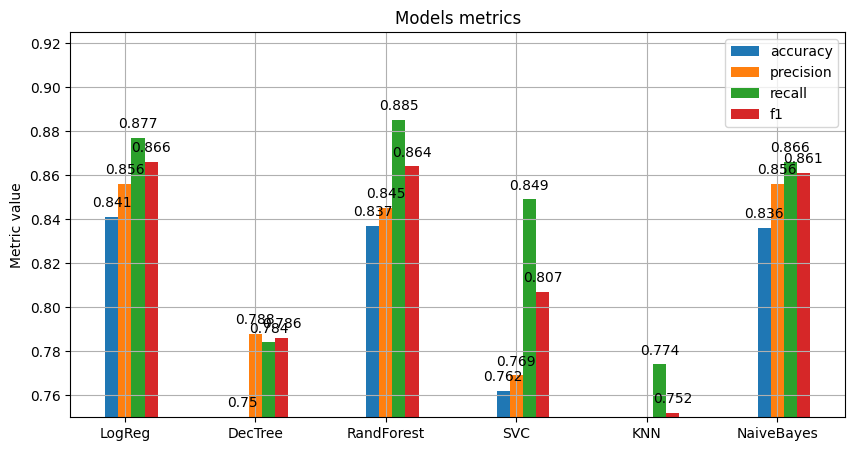

In [9]:
all_results = {metric_name: [] for metric_name in metrics.keys()}

for model, results in test_results.items():
    for metric, value in results.items():
        all_results[metric].append(np.array(value).mean())

x_loc = np.arange(len(models))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(10, 5))

for attribute, measurement in all_results.items():
    offset = width * multiplier
    rects = ax.bar(x_loc + offset, np.round(measurement, 3), width, label=attribute)
    ax.bar_label(rects, padding=5)
    multiplier += 1

ax.set_ylabel('Metric value')
ax.set_title('Models metrics')
ax.set_xticks(x_loc + width, [v[0] for v in models.values()])
ax.legend()
ax.grid()
ax.set_ylim(0.75, 0.925)

plt.show()

We can see that **Decision Tree** and **KNN** showed worst results in all metrics, hence we immediately drop them. **Random Decision Tree** demonstrated highest `recall` score compared to all models, but it showed sligtly worse results in other metrics, so we cannot pick this model right away either. On average it looks like **Logistic regression** model showed one of the best results, therefore, let us use this model for the predictions.

## Part 2. Simulate Play-Off

After the model has been slected we can move to the actual play-off simulations. But first, let us clarify play-off rules:

- 8 best teams in each conference (east and west) are divided into pairs
- The team that wins 4 mathces moves to the next round (*i.e.* maximum 7 matches for team pair)
- Eventually there is final round for the winners of east and west conferences
- Team that wins 4 matches in the finals becomes NBA champion

After rules are stated, let us define the general algorithm for simulation:

1. Filter games data for selected season
1. Train model on that data
1. Compute average performance per game for each team (*i.e.* average **FG_PCT, FT_PCT**, *etc*)
1. For each team pair we can generate small table with 7 rows of the same format that we used for training. However, teams cannot have the same percatnage of successful shots, number of assists and rebounds. Hence, we need to slightly change these numbers to add variability
1. Predict outcome of these 7 games and identify the winner
1. Repeat steps *4-5* for each team pair **N** number of times (101, for example, so there will not be a draw)
1. Select team with higher number of victories to move to the next round
1. Repeat steps *4-7* for all teams in east and west conferences
1. Simulate final round as in steps *4-6* for reamining team pair

For convenience let us make separate functions for some of the steps. Function to filter games for given season has been defined above (`filter_season_games`), other functions will be defined below.

### Train ML model for given season

After trying different models to simulate play-off I noticed that **Logistic Regression** shows better results, so I decided to use this model.

Here we just collect data about games for given season and train Logistic Regression model on collected data

In [10]:
def prepare_model(season_year: int) -> LogisticRegression:
    # This function takes season_year as an argument and trains the model on data for that season
    regular_season = filter_season_games(season_year) # get games for given season
    
    regular_season.loc[:, cols_to_norm] = scaler.fit_transform(regular_season.loc[:, cols_to_norm]) # scale specified columns
    X, y = regular_season.drop(["HOME_TEAM_WINS"], axis=1), regular_season["HOME_TEAM_WINS"] # split data into predictors and target

    # train model
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    
    return model


### Compute average data for each team for a gven season

For play-off simulation we will need average performance of a team in given season, hence, we need to prepare that data as well. For each team we find games in which that team participated (either at home or away) and compute mean value of required parameters. After that we can combine all data of each team into separate table.

In [44]:
def compute_statistics(season_year: int=2018) -> pd.DataFrame:
    # This function takes season_year and computes average data for each team
    if 2004 > season_year > 2022:
        print("NO DATA FOR THIS SEASON")
        return
    
    season_data = filter_season_games(season_year) # get games for given season
    
    teams_data = df_teams[["TEAM_ID", "ABBREVIATION"]] # extract team ID and abbreviation from other table 
    
    # columns to be extracted from season_data
    home_features = ['FG_PCT_home', 'FT_PCT_home',
                     'FG3_PCT_home', 'AST_home', 'REB_home']
    away_features = ['FG_PCT_away', 'FT_PCT_away',
                     'FG3_PCT_away', 'AST_away', 'REB_away']

    # for each team compute average values
    for team_row in teams_data.iterrows():
        idx, (team_id, _) = team_row[0], team_row[1].values

        # Get data when given team played at home
        home_data = season_data.loc[season_data["HOME_TEAM_ID"] == team_id, home_features]
        home_data = home_data.rename(columns={f: f[:-5] for f in home_features})

        # Get data when given team played away
        away_data = season_data.loc[season_data["VISITOR_TEAM_ID"] == team_id, away_features]
        away_data = away_data.rename(columns={f: f[:-5] for f in away_features})
        
        # Combine subtables
        temp_data = pd.concat([home_data, away_data])
        for col in temp_data.columns:
            teams_data.loc[idx, [col]] = temp_data.loc[:, [col]].mean()  
    
    local_cols_to_norm = ["AST", "REB"]
    teams_data.loc[:, local_cols_to_norm] = scaler.fit_transform(teams_data.loc[:, local_cols_to_norm]) # scalse columns with assists and rebounds
    
    return teams_data

print("This is the table with average performance of each team in given season")
compute_statistics().head()

This is the table with average performance of each team in given season


,TEAM_ID,ABBREVIATION,FG_PCT,FT_PCT,FG3_PCT,AST,REB
0,0.000000,ATL,0.451780,0.751817,0.350976,0.615385,0.611473
1,0.034483,BOS,0.465829,0.806378,0.363012,0.663625,0.445893
2,0.103448,NOP,0.474561,0.757463,0.344073,0.743155,0.739244
3,0.137931,CHI,0.454183,0.788293,0.349183,0.195567,0.268579
4,0.172414,DAL,0.447659,0.741524,0.341451,0.354628,0.528031


### Simulate play-off round for 2 given teams

Now let us create function to simulate single round for team pair. In real life one of the teams plays at home while the other becomes a visitor. During pay-off each round starts from 2 games in one city, then 2 games in other city, after that visit one another after each game. Let us apply the same order in simulation. Moreover, since we simulate each round **N** number of times, we can start each time in different order, *i.e.*, in one simluation **Team_1** may start round at home while in other it may start as visitor.

In [69]:
home_visitor_order = [True, True, False, False, True, False, True]
scale = 1/4

def simulate_play_off_round(team_pair: List[str], ml_model: LogisticRegression, season_statistics: pd.DataFrame) -> str:
    # This function takes team pair, pretrained model, stastics of each team for given season
    # and simulates play-off round for this pair (best in 7)
    
    np.random.shuffle(team_pair) # randomly set home and visitor teams
    team1, team2 = team_pair # team1 starts at home
    if team1 == team2:
        print("YOU ENTERED THE SAME TEAMS")
        return
    
    # extract corresponding average performance for each team
    team1_data = season_statistics.loc[season_statistics["ABBREVIATION"] == team1, :]
    team2_data = season_statistics.loc[season_statistics["ABBREVIATION"] == team2, :]
    
    # initialize columns of new small table
    home_team_id = [] # HOME_TEAM_ID
    away_team_id = [] # VISITOR_TEAM_ID

    fg_pct_home, ft_pct_home, fg3_pct_home = [], [], [] # FG_PCT_home, FT_PCT_home,	FG3_PCT_home
    ast_home, reb_home = [], [] # AST_home, REB_home

    fg_pct_away, ft_pct_away, fg3_pct_away = [], [], [] # FG_PCT_away, FT_PCT_away, FG3_PCT_away
    ast_away, reb_away = [], [] # AST_away, REB_away
    
    # switch home and visitor teams
    for hv in home_visitor_order:
        if hv:
            home_team = team1_data
            away_team = team2_data
        else:
            home_team = team2_data
            away_team = team1_data
        
        # append data in corrsponding columns and apply variability to the team statistics
        home_team_id.append(home_team["TEAM_ID"].iloc[0])
        fg_pct_home.append(np.random.normal(home_team["FG_PCT"].iloc[0], scale=scale))
        ft_pct_home.append(np.random.normal(home_team["FT_PCT"].iloc[0], scale=scale))
        fg3_pct_home.append(np.random.normal(home_team["FG3_PCT"].iloc[0], scale=scale))
        ast_home.append(np.random.normal(home_team["AST"].iloc[0], scale=scale))
        reb_home.append(np.random.normal(home_team["REB"].iloc[0], scale=scale))
        
        away_team_id.append(away_team["TEAM_ID"].iloc[0])
        fg_pct_away.append(np.random.normal(away_team["FG_PCT"].iloc[0], scale=scale))
        ft_pct_away.append(np.random.normal(away_team["FT_PCT"].iloc[0], scale=scale))
        fg3_pct_away.append(np.random.normal(away_team["FG3_PCT"].iloc[0], scale=scale))
        ast_away.append(np.random.normal(away_team["AST"].iloc[0], scale=scale))
        reb_away.append(np.random.normal(away_team["REB"].iloc[0], scale=scale))
    
    # merge data to create pandas.Dataframe
    cols = useful_columns
    data = {cols[0]: home_team_id,
            cols[1]: away_team_id,
            cols[2]: fg_pct_home,
            cols[3]: ft_pct_home,
            cols[4]: fg3_pct_home,
            cols[5]: ast_home,
            cols[6]: reb_home,
            cols[7]: fg_pct_away,
            cols[8]: ft_pct_away,
            cols[9]: fg3_pct_away,
            cols[10]: ast_away,
            cols[11]: reb_away}
    games = pd.DataFrame(data, columns=useful_columns[:-1])

    # predict games results
    results = ml_model.predict(games) 

    # iterate over predicted results and count number of victories for each team
    team1_wins, team2_wins = 0, 0
    for r, hv in zip(results, home_visitor_order):
        if r == 1:
            if hv:
                team1_wins += 1
            else:
                team2_wins += 1
        else:
            if hv:
                team2_wins += 1
            else:
                team1_wins += 1
        # if any of the teams has achieved 4 victories return its name
        if team1_wins == 4:
            return team1
        elif team2_wins == 4:
            return team2
    

### Compare results between 2 teams in different seasons

After we created the function to simulate play-off round for given team pair, we can simulate play-off round **N** times. Let us create separate function for that and add convenient visualization of results. Moreover, let us simulate play-off round for 2 teams in diffrent seasons.

In [70]:
num_of_sim = 101

def compute_probability_to_win_round(team_pair: List[str],
                                     model: LogisticRegression,
                                     season_statistics: pd.DataFrame,
                                     season_to_simulate: int,
                                     display_results=True) -> Dict[str, float]:
    # This function simulates play-off round N times for given team pair
    # and returns team with more won rounds

    teams_results = {team: 0 for team in team_pair} # counter of won rounds for each team

    # predict winner N times and increment corresponding counter
    for _ in range(num_of_sim):
        winner = simulate_play_off_round(team_pair, model, season_statistics)
        teams_results[winner] += 1 / num_of_sim

    # Print results if requested
    if display_results:
        print(f"\nSeason {season_to_simulate}-{season_to_simulate+1}")
        for t,w in teams_results.items():
            print(f"{t} won {w*100:.1f}% of rounds")

    # Sort results by probability of a victory, so the first team in pair is winner            
    teams_results = dict(sorted(teams_results.items(), key=lambda item: item[1], reverse=True))
    return teams_results

# Simulate single play-off round for 2 teams in 2 different seasons
year_list = [2015, 2019]
team_pair = ["LAL", "ATL"]
for season_to_simulate in year_list:
    compute_probability_to_win_round(team_pair,
                                     prepare_model(season_to_simulate),
                                     compute_statistics(season_to_simulate),
                                     season_to_simulate)


Season 2015-2016
LAL won 39.6% of rounds
ATL won 60.4% of rounds

Season 2019-2020
ATL won 49.5% of rounds
LAL won 50.5% of rounds


We can see that in different seasons different teams were stronger. Let's compare winning percantage with real data

In [ ]:
df_standing = pd.read_csv("data/ranking.csv") # read table with teams standing
df_standing = df_standing.loc[:, ["TEAM_ID", "STANDINGSDATE", "TEAM", "W_PCT"]] # keep only specific columns
df_standing.loc[:, ["TEAM_ID"]] = scaler.fit_transform(df_standing.loc[:, ["TEAM_ID"]]) # scale teams IDs
df_standing = pd.merge(df_standing, df_teams.loc[:, ["TEAM_ID", "ABBREVIATION"]], on="TEAM_ID") # add column with corresponding team abbreviation

print("Winning percentage")
# get team winning percentage for each season
for year in year_list:
    print(f"\nSeason {year}-{year+1}")
    season_end = season_schedule.loc[season_schedule["SEASON"] == year]["END"].iloc[0]
    cur_season_data = df_standing.loc[df_standing["STANDINGSDATE"] == season_end]

    for t in team_pair:
        w_pct = cur_season_data.loc[cur_season_data["ABBREVIATION"] == t]["W_PCT"].iloc[0]
        print(f"{t} won {w_pct*100:.1f}% of matches")


Winning percentage

Season 2015-2016
ATL won 58.5% of matches
LAL won 20.7% of matches

Season 2019-2020
ATL won 29.9% of matches
LAL won 74.3% of matches


We can see that in season 2015-2016 `LAL` won only 20% of their mathces while `ATL` won 58% percent of their matches, so probably `ATL` was stronger in that season, this proves our prediction above. However, in the season 2019-2020 winning percantage is other way around, which means `LAL` was stronger that season, as well as according to our prediction.

### Now let us simulate the entire play-off series for desired season

In [50]:
play_off_teams = pd.read_csv('data/play_off_teams.csv') # table with teams participating in play-off in each season
"""
SEASON: start year of the season, i.e. season 2004 is season 2004-2005
EAST_TEAMS: list of east teams participating in play-off
WEST_TEAMS: list of west teams participating in play-off
WINNER: team that became champion that season
RUNNER_UP: team that was in final round that season
"""
play_off_teams.head()

,SEASON,EAST_TEAMS,WEST_TEAMS,WINNER,RUNNER_UP
0,2004,"['DET', 'PHI', 'IND', 'BOS', 'MIA', 'BKN', 'WA...","['DAL', 'HOU', 'PHX', 'MEM', 'SAS', 'DEN', 'OK...",SAS,DET
1,2005,"['CLE', 'WAS', 'DET', 'MIL', 'MIA', 'CHI', 'BK...","['DAL', 'MEM', 'SAS', 'SAC', 'LAC', 'DEN', 'PH...",MIA,DAL
2,2006,"['CHI', 'MIA', 'DET', 'ORL', 'CLE', 'WAS', 'BK...","['GSW', 'DAL', 'UTA', 'HOU', 'PHX', 'LAL', 'SA...",SAS,CLE
3,2007,"['BOS', 'ATL', 'CLE', 'WAS', 'DET', 'PHI', 'OR...","['LAL', 'DEN', 'UTA', 'HOU', 'CHA', 'DAL', 'SA...",BOS,LAL
4,2008,"['ATL', 'MIA', 'CLE', 'DET', 'BOS', 'CHI', 'OR...","['DAL', 'SAS', 'DEN', 'CHA', 'HOU', 'POR', 'LA...",LAL,ORL


In the dataset teams stored in such order that $1^{st}$ team from the list plays with $2^{nd}$ team in list, $3^{rd}$ plays with $4^{th}$ and *etc*. Hence the idea is the following:
1. Get 2 teams from the list and simulate play-off round between them
2. Repeat step *1* for remaining teams
3. Update the list keeping only winners of each pair
4. Repeat steps *1-3* until only one team remains

We need to repeat the algorithm for east and west conference separately until there are only 2 tems remain. After that we can simulate the final round between them.

If we want we can print the predicted play-off results of either only final round or all rounds

In [51]:
def simulate_entire_play_off(season: int,
                             east_teams: List[str],
                             west_teams: List[str],
                             real_winner: str,
                             runner_up: str,
                             display_min_results: bool=False,
                             display_all_results: bool=False,
                             return_data: bool=True) -> Tuple[str, str]:
    # This function simulates entire play-off for given qualified teams and prints results if requested
    
    best_model = prepare_model(season) # train model on data for given season
    season_statistics = compute_statistics(season) # compute average performance of each team in given season
    
    # Print results if requested
    if display_min_results or display_all_results:
        print(f"Simulating {season}-{season+1} Play-Off")
    if display_all_results:
        print("\nEAST:")
    
    # iterate over teams in east conference until one team remains
    while len(east_teams) > 1:
        east_results = [] # list to store mathces results
        # Take each pair
        for i in range(0, len(east_teams), 2):
            # simulate play-off round and store results
            east_results.append(compute_probability_to_win_round([east_teams[i], east_teams[i+1]], 
                                                                 best_model,
                                                                 season_statistics,
                                                                 season,
                                                                 display_results=False))
        # Update list of teams keeping only those that won previous round
        east_teams = [list(res.items())[0][0] for res in east_results]
        # Display results if requested
        if display_all_results:
            for i in range(len(east_results)):
                winner = list(east_results[i].items())[0]
                loser = list(east_results[i].items())[1]
                print(f"{color.GREEN}{winner[0]}{color.END}({winner[1]:.2f}) defeated {color.RED}{loser[0]}{color.END}({loser[1]:.2f})")
            print()
    
    # repeat procedure of west conference
    # Print results if requested
    if display_all_results:
        print("\nWEST:")
    # iterate over teams in west conference until one team remains
    while len(west_teams) > 1:
        west_results = [] # list to store mathces results
        # Take each pair
        for i in range(0, len(west_teams), 2):
            # simulate play-off round and store results
            west_results.append(compute_probability_to_win_round([west_teams[i], west_teams[i+1]], 
                                                                 best_model,
                                                                 season_statistics,
                                                                 season,
                                                                 display_results=False))
        # Update list of teams keeping only those that won previous round
        west_teams = [list(res.items())[0][0] for res in west_results]
        # Display results if requested
        if display_all_results:
            for i in range(len(west_results)):
                winner = list(west_results[i].items())[0]
                loser = list(west_results[i].items())[1]
                print(f"{color.GREEN}{winner[0]}{color.END}({winner[1]:.2f}) defeated {color.RED}{loser[0]}{color.END}({loser[1]:.2f})")
            print()
    
    # Simulate final round between winner of east and west conferences
    final_result = compute_probability_to_win_round([east_teams[0], west_teams[0]], best_model, season_statistics, season, display_results=False)
    # Store winner team and other finalist
    winner = list(final_result.items())[0]
    loser = list(final_result.items())[1]
    # Display results if requested
    if display_min_results or display_all_results:
        print(f"According to the prediction {color.GREEN}{winner[0]}{color.END}({winner[1]:.2f}) defeated {color.RED}{loser[0]}{color.END}({loser[1]:.2f}) in finals")
        print(f"While in real life {color.GREEN}{real_winner}{color.END} defeated {color.RED}{runner_up}{color.END} in finals\n")

    if return_data:
        return winner, loser

This is how *minimal dusplay* would look, where green team is winner, red - loser and number in the brackets is the percentage of won rounds between these 2 teams 

In [ ]:
for row in play_off_teams.iterrows():
    # get data from table
    season_year, east_teams, west_teams, real_winner, real_loser = row[1].values

    # # filter rows with team pairs from table
    east_teams = [t[1:-1] for t in east_teams[1: -1].split(', ')]
    west_teams = [t[1:-1] for t in west_teams[1: -1].split(', ')]
    simulate_entire_play_off(season_year, east_teams, west_teams, real_winner, real_loser, display_min_results=True, return_data=False)
    break

Simulating 2004-2005 Play-Off
According to the prediction PHX(0.64) defeated MIA(0.36) in finals
While in real life SAS defeated DET in finals



This is how *full dusplay* would look, where green team is winner, red - loser and number in the brackets is the percentage of won rounds between these 2 teams. First, we see results of the first round in **east** conference, then 2 round and finally the conference finals. After that the same information for **west** conference. Finally, we see the predicted finals results compared with actual results.

In [ ]:
for row in play_off_teams.iterrows():
    # get data from table
    season_year, east_teams, west_teams, real_winner, real_loser = row[1].values

    # # filter rows with team pairs from table
    east_teams = [t[1:-1] for t in east_teams[1: -1].split(', ')]
    west_teams = [t[1:-1] for t in west_teams[1: -1].split(', ')]
    simulate_entire_play_off(season_year, east_teams, west_teams, real_winner, real_loser, display_all_results=True, return_data=False)
    break

Simulating 2004-2005 Play-Off

EAST:
DET(0.73) defeated PHI(0.27)
BOS(0.73) defeated IND(0.27)
MIA(0.67) defeated BKN(0.33)
CHI(0.61) defeated WAS(0.39)

DET(0.58) defeated BOS(0.42)
MIA(0.53) defeated CHI(0.47)

DET(0.53) defeated MIA(0.47)


WEST:
HOU(0.54) defeated DAL(0.46)
PHX(0.79) defeated MEM(0.21)
DEN(0.53) defeated SAS(0.47)
SAC(0.78) defeated OKC(0.22)

PHX(0.58) defeated HOU(0.42)
SAC(0.59) defeated DEN(0.41)

PHX(0.56) defeated SAC(0.44)

According to the prediction PHX(0.56) defeated DET(0.44) in finals
While in real life SAS defeated DET in finals



We can see that the model is not really accurate. It predicted wrong champion, but occasionally it predicts correct finalist (**DET** or **MIA**). We can see that in the last round of **east** conference the score between **DET** and **MIA** is really close and that is the variability that we wanted to achieve. Actually, if we check the official information about [play-off in that season](https://www.basketball-reference.com/playoffs/NBA_2005.html), we sill see that **DET** and **MIA** indeed met in the conference finals and the score between them was 4-3, which means that teams were equally strong, so our prediction may not be that bad.

In [ ]:
real_winners, real_losers = [], [] # lists to store actual winners and losers in final round
pred_winners, pred_losers = [], [] # lists to store predicted winners and losers in final round
incorrect_seasons = [] # list for seasons with wrong winner predictions
# Iterate over each season and simulate entire play-off
for row in tqdm(play_off_teams.iterrows()):
    # get data from table
    season_year, east_teams, west_teams, real_winner, real_loser = row[1].values

    # filter rows with team pairs from table
    east_teams = [t[1:-1] for t in east_teams[1: -1].split(', ')]
    west_teams = [t[1:-1] for t in west_teams[1: -1].split(', ')]

    # Save real winner and loser for current season
    real_winners.append(real_winner)
    real_losers.append(real_loser)

    # Simulate entire play-off and store predicted winner and loser
    pred_winner, pred_loser = simulate_entire_play_off(season_year, east_teams, west_teams, real_winner, real_loser)
    pred_winners.append(pred_winner[0])
    pred_losers.append(pred_loser[0])

    # If predicted winner differs from actual winner, save that season to analyze the reasons of incorect prediction
    if pred_winner[0] != real_winner:
        incorrect_seasons.append((season_year, pred_winner[0]))

18it [02:03,  6.87s/it]


#### Let us check how many correct results were given

In [ ]:
# Compute accuracy for predicted winners and losers
print(f"Winners accuracy: {accuracy_score(real_winners, pred_winners)}")
print(f"Losers accuracy: {accuracy_score(real_losers, pred_losers)}")

Winners accuracy: 0.2777777777777778
Losers accuracy: 0.05555555555555555


We can see that only $\leq1/3$ of winners were predicted correctly, *i.e.* around 6/18 correct champions, while other finalists were predicted even worse. Nevertheless, if we think about it, there are many variables that can affect match outcome that we didn't consider. For example, some players may be injured and not able to play, or lead player may be disqualified from the match because of high number of fouls and *etc.* This means, that desgined model should work correctly in ideal scenario, however, there are more parameters to be taken into account. 

Anyway, let us consider in details seasons with wrong predictions and analyze why the prediction was wrong. For example, let us take a look at 2015-2016 play-off. On the east side there were **Cleveland Cavaliers (CLE)** with legendary LeBron James (4x-MVP, 2x-NBA champion), Kyrie Irving and, of course, Timofey Mozgov. On the other side there was a dinasty of **Golden State Warriors (GSW)** (73-9) with Stephen Curry (1x-NBA champion, 2x-MVP), Kevin Durant (1x-MVP) and  Klay Thompson (multiple 3PT records holder). It was clear to everyone that **GSW** would win that title again especially after 3-1 lead in the finals (they needed only 1 victory). However, everyone in Cleveland ate something (I do not know what else pushed them that much) and were able to, first, even the score in series, and, eventually, win the title. They also became the first team in NBA history (and still are) that achieved successful recovery after being down 3-1

In [71]:
season = 2015

season_year, east_teams, west_teams, real_winner, real_loser = play_off_teams.loc[play_off_teams["SEASON"] == season].values[0]

east_teams = [t[1:-1] for t in east_teams[1: -1].split(', ')]
west_teams = [t[1:-1] for t in west_teams[1: -1].split(', ')]

simulate_entire_play_off(season_year, east_teams, west_teams, real_winner, real_loser, display_all_results=True, return_data=False)

Simulating 2015-2016 Play-Off

EAST:
BOS(0.53) defeated ATL(0.47)
CLE(0.52) defeated DET(0.48)
MIA(0.55) defeated CHA(0.45)
IND(0.54) defeated TOR(0.46)

CLE(0.61) defeated BOS(0.39)
IND(0.58) defeated MIA(0.42)

CLE(0.51) defeated IND(0.49)


WEST:
GSW(0.63) defeated HOU(0.37)
LAC(0.51) defeated POR(0.49)
OKC(0.56) defeated DAL(0.44)
SAS(0.62) defeated MEM(0.38)

GSW(0.65) defeated LAC(0.35)
OKC(0.52) defeated SAS(0.48)

GSW(0.56) defeated OKC(0.44)

According to the prediction GSW(0.54) defeated CLE(0.46) in finals
While in real life CLE defeated GSW in finals



Or we can take a look at 2010-2011 play-off. **Dallas Maverics (DAL)** indeed reached the final round as model predicted. However, in real life they had different opponent: **Miami Heat (MIA)**, who accroding to prediction lost in $1^{st}$ round, which is totally incorrect. However, **Chicago Bulls (CHI)** indeed were strong that season, they had the youngest MVP - Derric Rose, and they won 2 rounds without many problems but lost to **Miami Heat (MIA)** in conference finals. Moreover, during the season **Chicago Bulls (CHI)** played with **Dallas Maverics (DAL)** twice and won both games, maybe this also affected the prediction in final round.

In [83]:
season = 2010

season_year, east_teams, west_teams, real_winner, real_loser = play_off_teams.loc[play_off_teams["SEASON"] == season].values[0]

east_teams = [t[1:-1] for t in east_teams[1: -1].split(', ')]
west_teams = [t[1:-1] for t in west_teams[1: -1].split(', ')]

simulate_entire_play_off(season_year, east_teams, west_teams, real_winner, real_loser, display_all_results=True, return_data=False)

Simulating 2010-2011 Play-Off

EAST:
ATL(0.53) defeated ORL(0.47)
CHI(0.53) defeated IND(0.47)
BOS(0.50) defeated NYK(0.50)
PHI(0.55) defeated MIA(0.45)

CHI(0.50) defeated ATL(0.50)
PHI(0.50) defeated BOS(0.50)

CHI(0.51) defeated PHI(0.49)


WEST:
DAL(0.68) defeated POR(0.32)
LAL(0.56) defeated CHA(0.44)
MEM(0.52) defeated SAS(0.48)
DEN(0.54) defeated OKC(0.46)

DAL(0.53) defeated LAL(0.47)
DEN(0.68) defeated MEM(0.32)

DAL(0.50) defeated DEN(0.50)

According to the prediction CHI(0.51) defeated DAL(0.49) in finals
While in real life DAL defeated MIA in finals



## Conclusion:

The model occasionally gives correct results for NBA champion, but it still can be extended. For example, as stated before we can take into account performance of each player individually in each game and train model on that data. Luckily, the source [Basketball reference](https://www.basketball-reference.com/) provides this data as well. Hence we can add paramaters like injury or number of fouls to the model, which should potentially improve performance